In [20]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["ex10", "msc04515", "s1rmq4m1", "Na5", "bcsstk18",
                "vibrobox", "cbuckle", "Pres_Poisson", "raefsky4", "vanbody",
                "ct20stif", "cant", "bcircuit", "apache1", "consph"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./overhead_analysis.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [21]:
if "running_all" not in globals():
    matrix = "cant"  # manually set to run over one matrix
matrix

'cant'

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from json import load
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from io_utils import load_models, load_matrices_from_dir

In [23]:
ylims = {
    "apache1": (0, 0.25),
    "bcircuit": (0, 1.5),
    "bcsstk18": (0.2, 1.5),
    "cant": (0.6, 1.5),
    "cbuckle": (0, 1.5),
    "consph": (0, 0.03),
    "ct20stif": (0, 1.5),
    "ex10": (0, 1.5),
    "msc04515": (0, 0.5),
    "Na5": (0, 1),
    "Pres_Poisson": (0, 0.6),
    "raefsky4": (0, 0.2),
    "s1rmq4m1": (0, 1.5),
    "vanbody": (0.9, 1.05),
    "vibrobox": (0.2, 1.5),
}

TESTING_DATA_SIZE = 1000

df = pd.read_csv(f"data/{matrix}_{TESTING_DATA_SIZE}.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,cant.mat,394,0.000001,39400,26110,339,8571,9.898982e-07,True,55.580377,4378.366731,62451,21.753807
1,cant.mat,394,0.000001,39400,38879,385,1219,9.942652e-07,True,7.981440,2405.097831,62451,3.093909
2,cant.mat,394,0.000001,39400,4442,130,14725,9.806331e-07,True,95.089715,8022.330094,62451,37.373096
3,cant.mat,394,0.000001,39400,52002,370,8819,9.935520e-07,True,56.921501,2174.561978,62451,22.383249
4,cant.mat,394,0.000001,39400,48322,283,39399,7.035883e-06,False,254.006677,8022.330094,62451,99.997462


In [24]:
chosen_models = {
    "apache1": "XGBRegressor",
    "bcircuit": "XGBRegressor",
    "bcsstk18": "XGBRegressor",
    "cant": "KNeighborsRegressor",
    "cbuckle": "KNeighborsRegressor",
    "consph": "Ridge",
    "ct20stif": "XGBRegressor",
    "ex10": "RandomForestRegressor",
    "msc04515": "RandomForestRegressor",
    "Na5": "XGBRegressor",
    "Pres_Poisson": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "s1rmq4m1": "RandomForestRegressor",
    "vanbody": "RandomForestRegressor",
    "vibrobox": "KNeighborsRegressor",
}

model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=2, p=1.0))])

In [25]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,cant.mat,394,0.000001,39400,26110,339,8571,9.898982e-07,True,55.580377,4378.366731,62451,21.753807,30.807107
1,cant.mat,394,0.000001,39400,38879,385,1219,9.942652e-07,True,7.981440,2405.097831,62451,3.093909,5.133249
2,cant.mat,394,0.000001,39400,4442,130,14725,9.806331e-07,True,95.089715,8022.330094,62451,37.373096,38.105330
3,cant.mat,394,0.000001,39400,52002,370,8819,9.935520e-07,True,56.921501,2174.561978,62451,22.383249,20.152284
4,cant.mat,394,0.000001,39400,48322,283,39399,7.035883e-06,False,254.006677,8022.330094,62451,99.997462,99.997462


In [26]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<62451x62451 sparse matrix of type '<class 'numpy.float64'>'
	with 4007383 stored elements in Compressed Sparse Column format>

In [27]:
with open(f"../matrices/2norms/{matrix}_pos_2norms.json") as f:
    pos_2norms = load(f)

In [28]:
df_preds = pd.DataFrame([[i, pos_2norms[str(pos)], pos] for pos in range(mat.shape[0])
                         for i in range(errorfree_iterations)], columns=["i", "2norm", "rowid"])

In [29]:
df_preds["output"] = model.predict(df_preds[["i", "2norm"]])
df_preds.head()

/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


,i,2norm,rowid,output
0,0,1319.685023,0,1.427665
1,1,1319.685023,0,1.427665
2,2,1319.685023,0,1.427665
3,3,1319.685023,0,1.427665
4,4,1319.685023,0,1.427665


In [30]:
ps = [1/98] + list(np.arange(0.02, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [31]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count

def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))

def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                         for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [32]:
nonprot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    nonprot_overheads = compute_overheads(solve_iterations[:data_size], 0)
    nonprot_overheads_by_p.append(nonprot_overheads)

nonprot_df = make_p_overhead_dataframe(nonprot_overheads_by_p)

In [33]:
prot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
    # always be False for nonerror runs, but this is fine because n_protections is computed
    # later for the purposes of calculating overhead
    protections = np.append(df["prot_score"] > (1 + (1 / p)), [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = (df_preds["output"] > (1 + (1 / p))).sum()

    prot_overheads = compute_overheads(prot_iterations, n_protections)
    prot_overheads_by_p.append(prot_overheads)

prot_df = make_p_overhead_dataframe(prot_overheads_by_p)

In [34]:
random_overheads = []
for perc in percentages:
    protections = np.random.rand(len(df)) < perc
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    random_overheads.append(prot_overheads.mean())
    
best_random_percentage = percentages[np.argmin(random_overheads)]
rand_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    protections = np.random.rand(data_size) < best_random_percentage

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = int(errorfree_iterations * n_rows * best_random_percentage)
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    rand_overheads_by_p.append(prot_overheads)

rand_df = make_p_overhead_dataframe(rand_overheads_by_p)

In [35]:
r2ns = np.array(list(pos_2norms.values()))
r2n_overheads = []
for perc in percentages:
    cutoff = np.quantile(r2ns, 1 - perc)
    protections = df["pos_2norm"] >= cutoff
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads.append(prot_overheads.mean())

best_r2n_percentage = percentages[np.argmin(r2n_overheads)]
cutoff = np.quantile(r2ns, 1 - best_r2n_percentage)
r2n_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    protections = np.append(df["pos_2norm"] >= cutoff, [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads_by_p.append(prot_overheads)

r2n_df = make_p_overhead_dataframe(r2n_overheads_by_p)

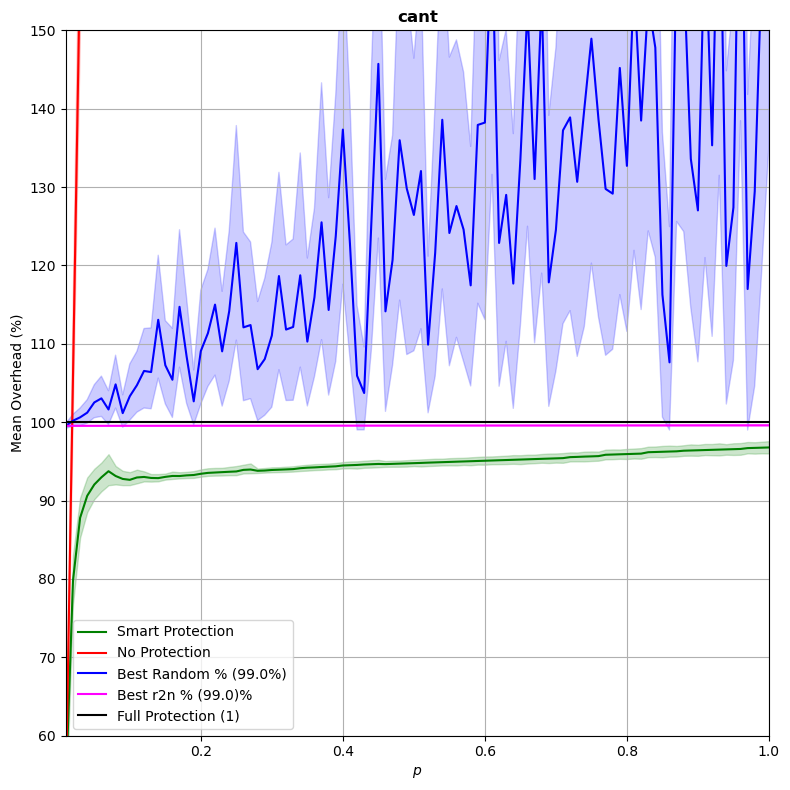

In [36]:
plt.gcf().set_size_inches(8, 8)
plt.gcf().set_dpi(100)

sns.lineplot(prot_df, x="p", y="overhead",
         label="Smart Protection", c="green")
sns.lineplot(nonprot_df, x="p", y="overhead",
             label="No Protection", c="red")
sns.lineplot(rand_df, x="p", y="overhead",
             label=f"Best Random % ({best_random_percentage * 100}%)", c="blue")
sns.lineplot(r2n_df, x="p", y="overhead",
             label=f"Best r2n % ({best_r2n_percentage * 100})%", c="magenta")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")

def formatter(x, pos):
    del pos
    return str(round(x * 100))

plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel("$p$")
plt.ylabel("Mean Overhead (%)")
plt.title(f"{matrix}", weight="bold")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(*ylims[matrix])
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

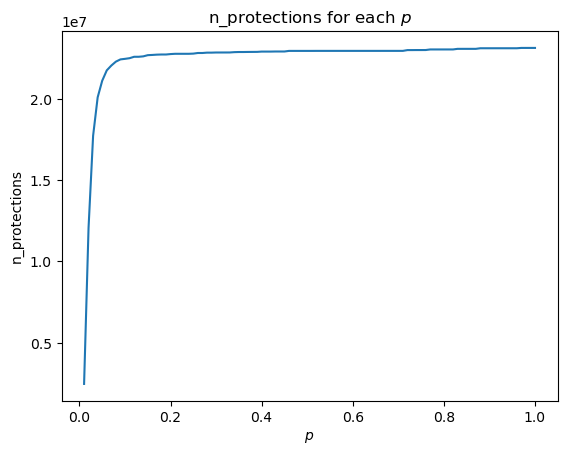

In [37]:
n_prots_per_p = []

for p in ps:
    n_protections = (df_preds["output"] > (1 + (1 / p))).sum()
    n_prots_per_p.append(n_protections)

s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.savefig(f"./figures/{matrix}/n_protections_for_each_p.png")
plt.show()

In [38]:
prot_avgs = prot_df.groupby("p").mean().rename(columns={"overhead": "prot_overhead"})
nonprot_avgs = nonprot_df.groupby("p").mean().rename(columns={"overhead": "nonprot_overhead"})
rand_avgs = rand_df.groupby("p").mean().rename(columns={"overhead": "rand_overhead"})
r2n_avgs = r2n_df.groupby("p").mean().rename(columns={"overhead": "r2n_overhead"})

avgs = prot_avgs.merge(nonprot_avgs, on="p").merge(rand_avgs, on="p").merge(r2n_avgs, on="p")
avgs.to_csv(f"./figures/{matrix}/mean_overheads.csv")
avgs

,prot_overhead,nonprot_overhead,rand_overhead,r2n_overhead
p,,,,
0.010204,0.540753,0.540584,0.995362,0.995396
0.020000,0.798030,1.059545,1.001953,0.995402
0.030000,0.878063,1.589334,1.006225,0.995409
0.040000,0.906102,2.119091,1.012183,0.995416
0.050000,0.920496,2.648863,1.025255,0.995423
...,...,...,...,...
0.960000,0.965880,50.890748,1.826318,0.996059
0.970000,0.966979,51.434242,1.169927,0.996066
0.980000,0.967243,51.938499,1.294434,0.996073
